In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

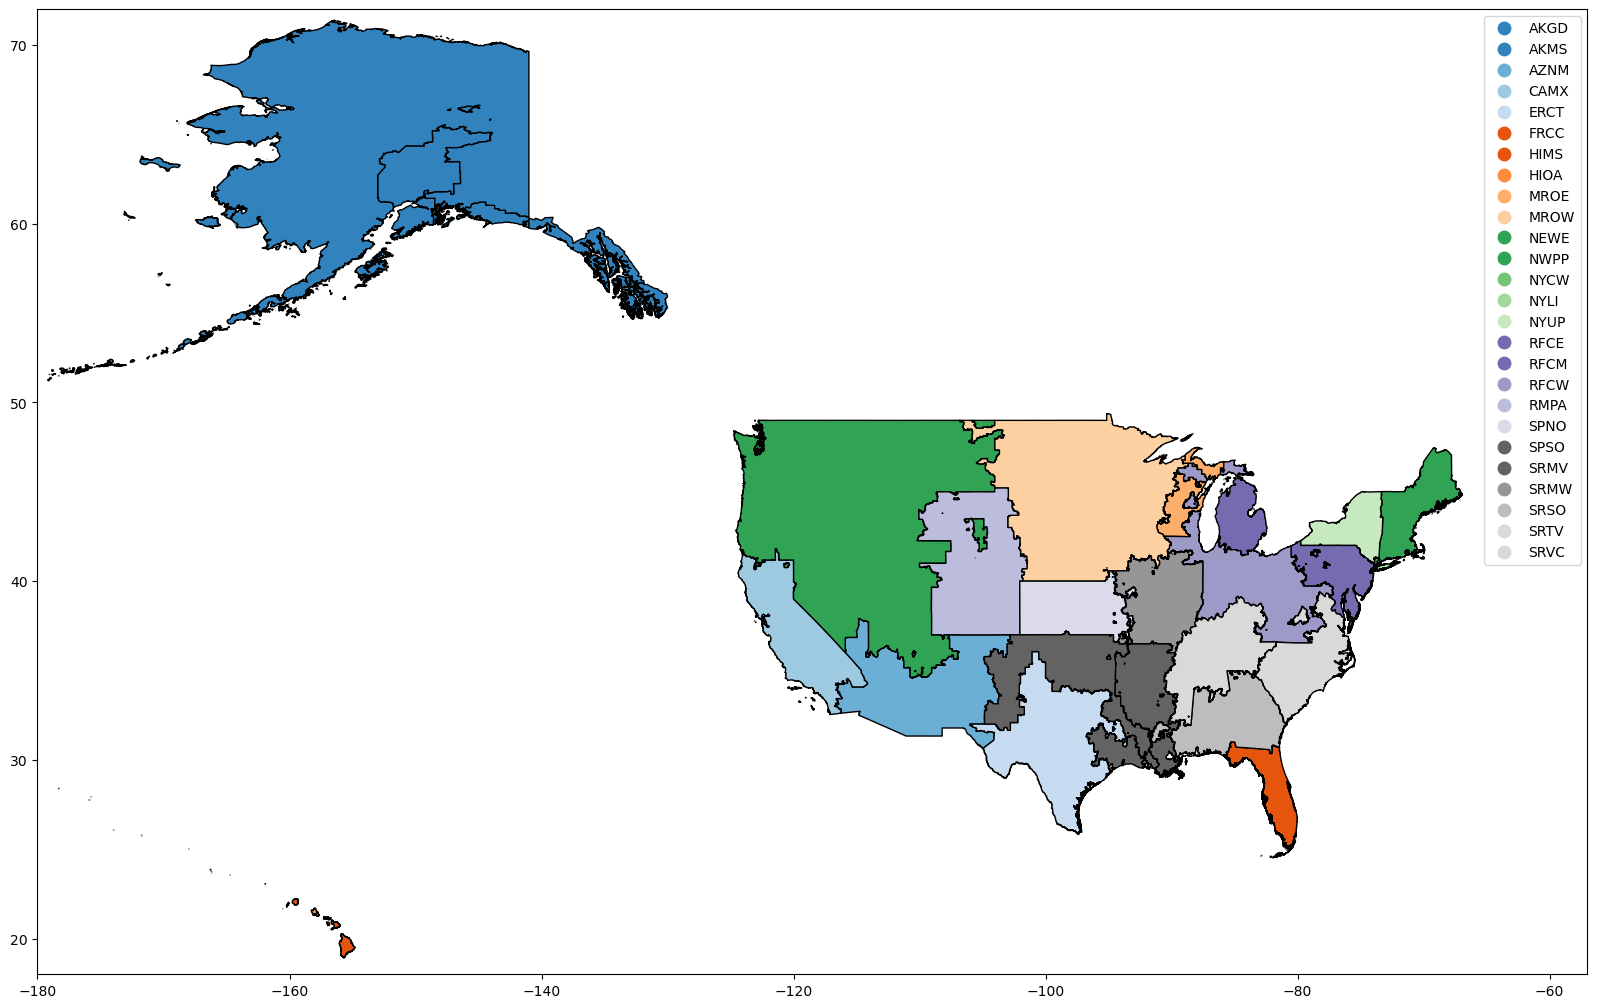

In [2]:
# Read in GeoJSON file containing the geometry information for US counties, where feature.id is a FIPS code
counties = gpd.read_file(
    'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')

# Read in eGRID subregions shapefile into geopandas (downloaded from https://www.epa.gov/egrid/egrid-mapping-files)
egrid_subregions = gpd.read_file(
    '../Input/egrid_2016_subregions_shapefiles/eGRID2016 Subregions.shp').rename(columns={'Subregions': 'SUBRGN'})

# Plot eGrid subregions
fig, ax = plt.subplots(figsize=(20, 20))

xlim = ([-180,  -57])
ylim = ([18,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

egrid_subregions.plot(edgecolor='black', column='SUBRGN',
                      cmap='tab20c', ax=ax, legend=True)

plt.show()

In [3]:
# Ensure CRS of both geodataframes are the same
if counties.crs == egrid_subregions.crs:
    print('CRS match - OK')
else:
    egrid_subregions.to_crs(counties.crs, inplace=True)
    print('CRS updated - OK')

CRS match - OK


c:\Users\kaili\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


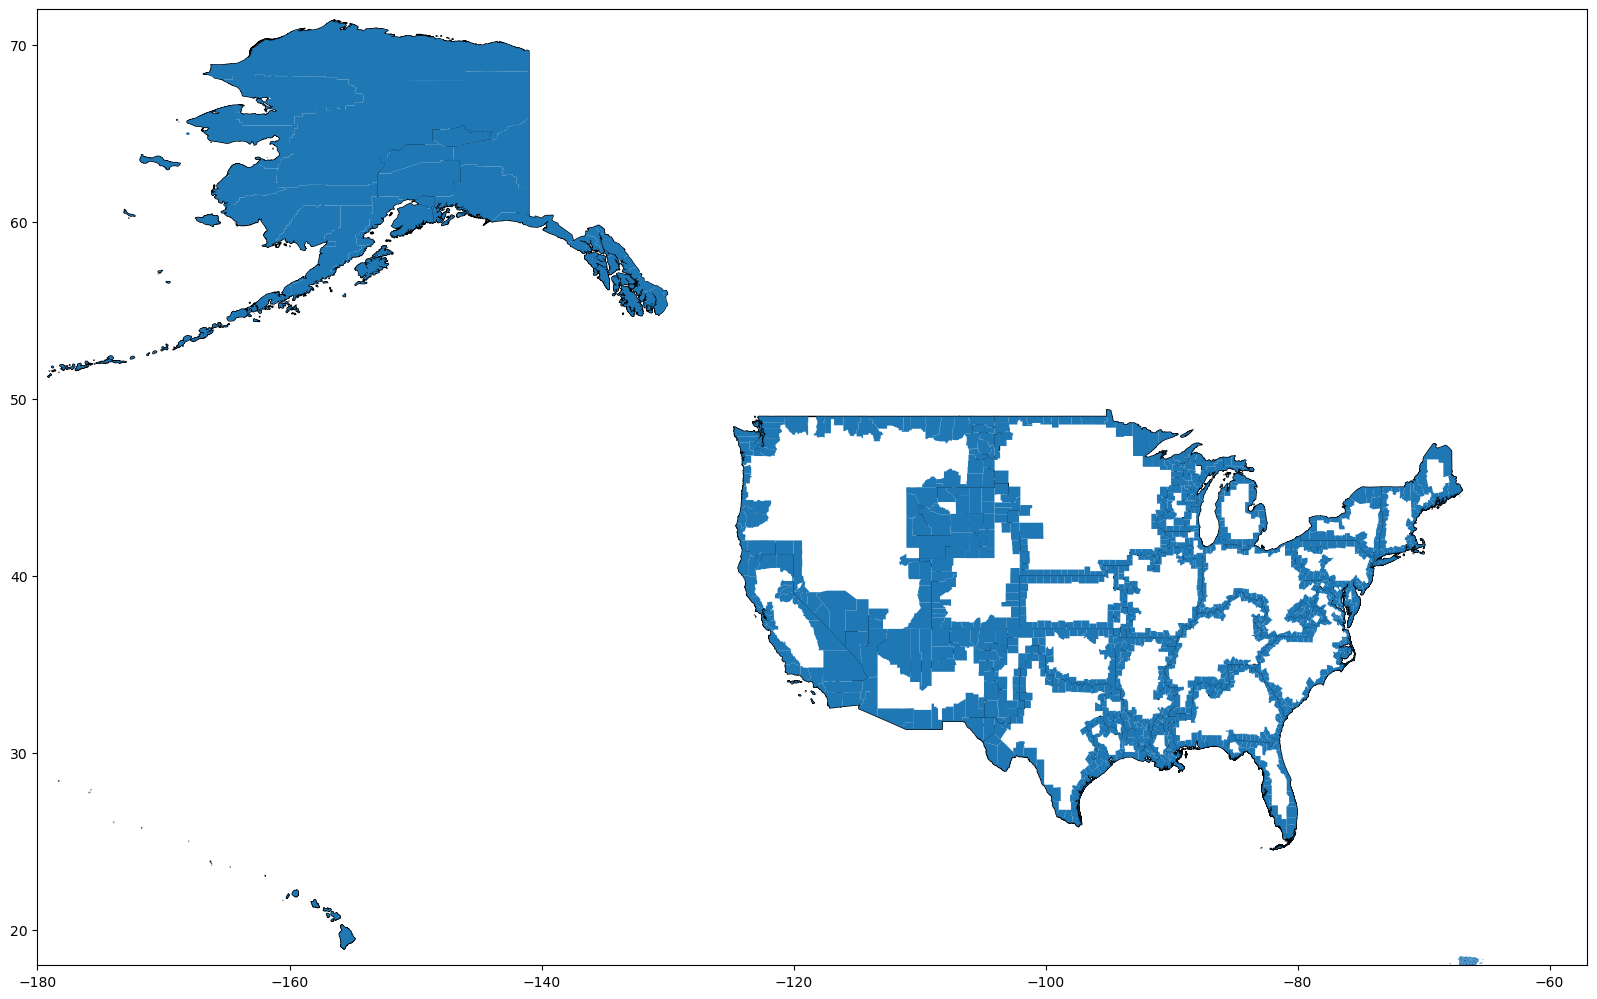

In [4]:
# Read in eGRID subregion emissions intensities in lbCO2e/MWh.
# Code for emissions intensity = SRC2ERTA (downloaded from https://www.epa.gov/egrid/download-data)
egrid_subregions_intensities = pd.read_excel(
    '../Input/egrid2016_data.xlsx', sheet_name=6, header=1)

# Merge emissions intensities onto subregions geodataframe
egrid_subregions = pd.merge(
    egrid_subregions,
    egrid_subregions_intensities[['SUBRGN', 'SRC2ERTA']],
    how='left',
    on='SUBRGN'
)

# Perform spatial join between counties and egrid_subregions to add emissions intensity data to each county
#  Perform spatial join for counties wholly within egrid subregions (those not wholly within will yield NaNs)
counties_intensities = gpd.sjoin(counties, egrid_subregions[[
                                 'geometry', 'SUBRGN', 'SRC2ERTA']], how='left', op='within')

#  Plot counties that yielded NaNs
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

egrid_subregions.plot(color='white', edgecolor='black', ax=ax)
counties_intensities[counties_intensities['SUBRGN'].isna()].plot(
    ax=ax, legend=True)

plt.show()

From the above, it can be seen that the counties that touch a boundary of an eGRID subregion yield NaN values.

In [5]:
## Isolate these counties
gdf = counties_intensities[counties_intensities['SUBRGN'].isna()]
gdf = gdf.drop(gdf.columns[-3:], axis = 1)

## Perform geopandas overlay to create a new geodataframe containing all of the different intersection points between each county and the eGRID regions
## i.e. if a county intersects with 2 different eGRID subregions, its FIPS will be listed twice, with different geometries and different eGRID subregion data
counties_assigned = gpd.overlay(gdf, egrid_subregions[['geometry', 'SUBRGN', 'SRC2ERTA']], how = 'intersection')

C:\Users\kaili\AppData\Local\Temp\ipykernel_27968\2960865334.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 2968 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  counties_assigned = gpd.overlay(gdf, egrid_subregions[['geometry', 'SUBRGN', 'SRC2ERTA']], how = 'intersection')


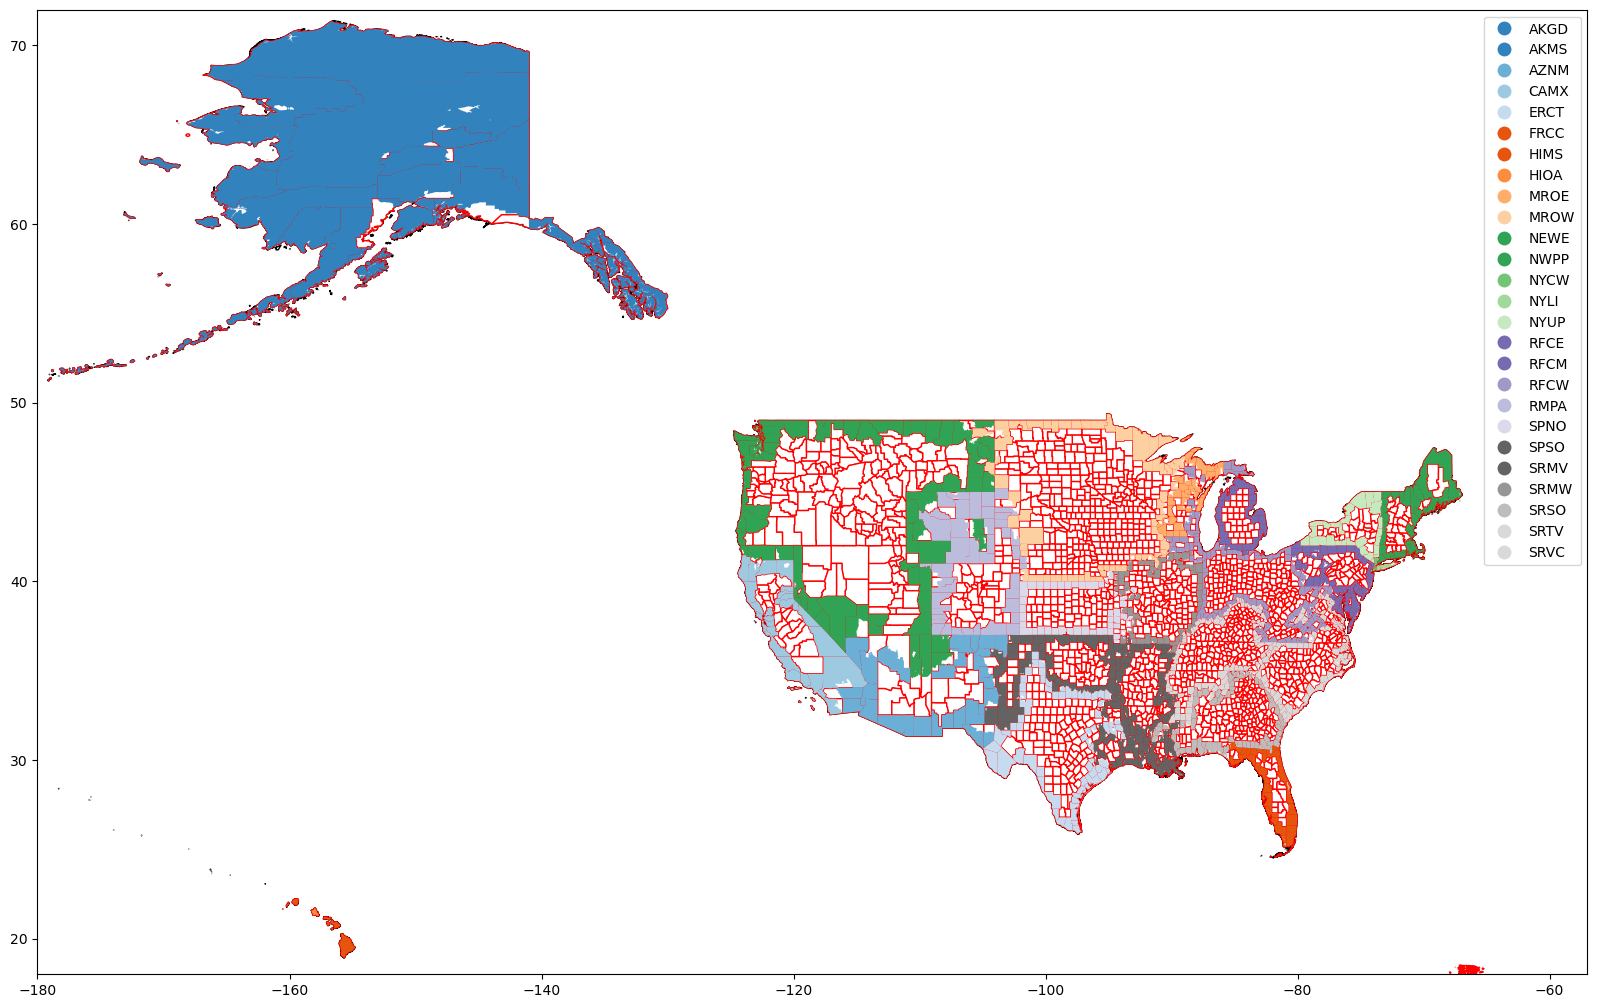

In [6]:
# Sort geodataframe by area so that the county subsection with the largest area is last for all counties with double-ups
counties_assigned.sort_values(
    by='geometry', inplace=True, key=lambda col: np.array([x.area for x in col]))

# Drop duplicates, keeping the last (i.e. the largest) of each of the double ups.
# For a county that intersects two different eGRID subregions, this keeps the larger of the intersections.
counties_assigned.drop_duplicates(subset='id', keep='last', inplace=True)

# Visually inspect this assignment
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

egrid_subregions.plot(color='white', edgecolor='black', ax=ax)
counties.plot(color='white', edgecolor='red', ax=ax)
counties_assigned[counties_assigned['LSAD'] != 'City'].plot(
    column='SUBRGN', cmap='tab20c', ax=ax,  legend=True)

plt.show()

In [7]:
# Drop all other data apart from FIPS code, eGRID subregion and the emissions intensity of that subregion, 
# and merge this data onto the original counties_intensities dataframe to replace the NaNs
counties_intensities_final = pd.merge(counties_intensities, counties_assigned[[
                                      'id', 'SUBRGN', 'SRC2ERTA']], how='left', on='id')

#  Get rid of old subregion and emissions intensity fields for previously NaN counties
counties_intensities_final['SUBRGN'] = counties_intensities_final.apply(
    lambda x: x.SUBRGN_x if x.index_right >= 0 else x.SUBRGN_y, axis=1)
counties_intensities_final['SRC2ERTA'] = counties_intensities_final.apply(
    lambda x: x.SRC2ERTA_x if x.index_right >= 0 else x.SRC2ERTA_y, axis=1)
counties_intensities_final = counties_intensities_final.drop(
    columns=['SUBRGN_x', 'SUBRGN_y', 'SRC2ERTA_x', 'SRC2ERTA_y'])

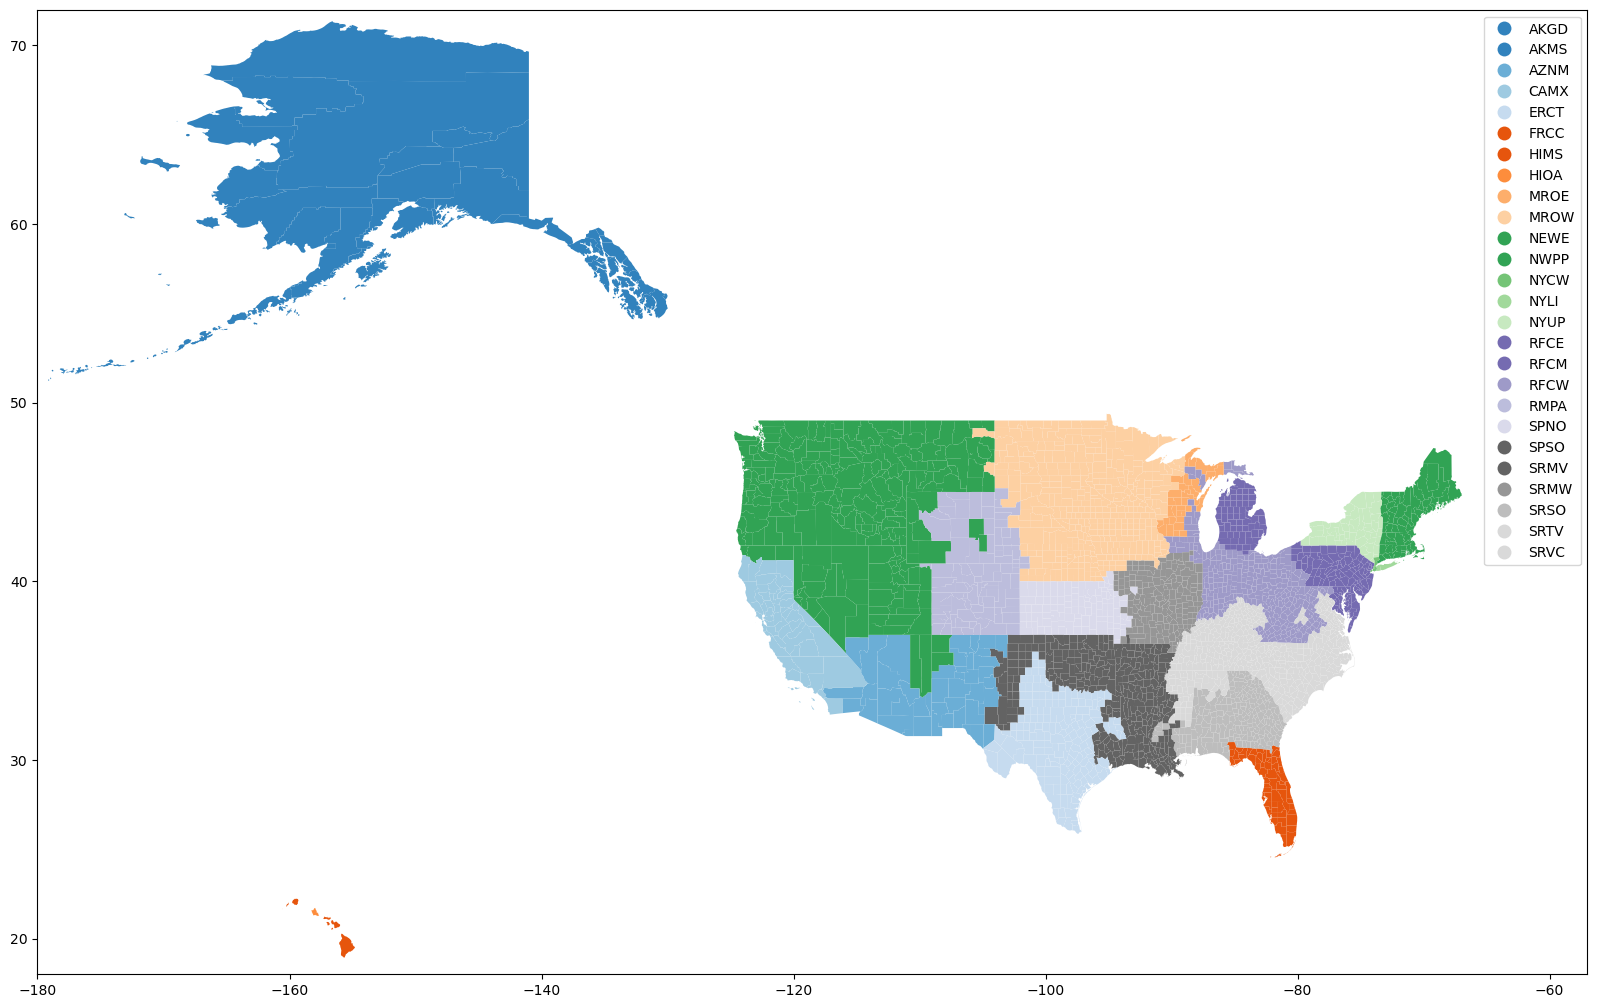

In [8]:
# Plot final counties
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

counties_intensities_final[counties_intensities_final['SUBRGN'].isna(
) == False].plot(column='SUBRGN', cmap='tab20c', ax=ax,  legend=True)

plt.show()

In [9]:
# Export to csv
counties_intensities_final.to_csv('../Temp/counties_elec_intensity.csv')